EE488 HW #2: Training VAE in FashionMNIST
====
TA : JongSuk Kim

TA's E-mail : jskpop@kaist.ac.kr

### ***Due Date: 3/30(Wed) 11:59 P.M.***

(Late Submssion due: 4/6(Wed) 11:59 P.M.)

## Instruction
- In this HW, you will implement your own VAE network based on convolution neural network and transposed convolution neural network for generating FashionMNIST like image

## Grading
- Total score is 10 points.(8 points + 2 points)

- Below is grading rule 
    - **Backbone**(8 points)
        - **You should make backbone network same with given config.**
        - Fully functional with required dimension matching : 8 points
        - Fully functional without required dimension matching : 7 points
        - Non functional : 6 points

    - **Problem**(2 points)
        - Using the mean value of the latent space, generate "Ankle boot" class image to "T-shirt/top" class image.

## Questions
- Please use QnA board in KLMS and **Classum**. When you post questions, please make it public so that all students can share the information. Please use the prefix "[HW 2]" in the subject for all questions regarding this homework


In [ ]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision 
import torchvision.datasets as vision_dsets
import torchvision.transforms as T 
import torch.optim as optim
from torch.autograd import Variable 
from torch.utils import data
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
root='./data'
batch_size=32

fmnist_train = vision_dsets.FashionMNIST(root = root,  
                                train = True,  
                                transform = T.ToTensor(),
                                download = True) 

fmnist_test = vision_dsets.FashionMNIST(root = root,
                                train = False, 
                                transform = T.ToTensor(),
                                download = True)

trainDataLoader = data.DataLoader(dataset = fmnist_train,  
                                    batch_size = batch_size, 
                                    shuffle =True, 
                                    num_workers = 1) 

testDataLoader = data.DataLoader(dataset = fmnist_test, 
                                batch_size = batch_size,
                                shuffle = False, 
                                num_workers = 1) 


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



### Backbone (8 points)

This [document](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) shows the relationship between input dimension, output dimension, and kernel config when you using nn.Conv2d and [document](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) for nn.ConvTranspose2d

Check this information and configure the encoder decoder layer so that the output shapes for each layer are as follows.
- Encoder
    - Input data shape: [batch_size, 1, 28, 28] 
    - encconv1 layer output shape: [batch_size, 8, 22, 22]
    - encconv2 layer output shape: [batch_size, 16, 18, 18]
    - encconv3 layer output shape: [batch_size, 32, 16, 16]
    - Encoder FC layer input shape: [batch_size, 32 \* 16 \* 16]
    - Encoder FC layer output(mean, variance) shape: [batch_size, z_dim]
- Decoder(Symmetric with Encoder)
    - Input latent(Decoder FC layer input) shape: [batch_size, z_dim]
    - Decoder FC layer output shape: [batch_size, 32 \* 16 \* 16]
    - decconv1 layer output shape: [batch_size, 16, 18, 18]
    - decconv2 layer output shape: [batch_size, 8, 22, 22]
    - decconv3 layer output shape: [batch_size, 1, 28, 28]
- **Notes**
    - In this case, you can change only in_channels, out_channels, kernel_size in nn.Conv2d and nn.ConvTranspose2d function
    - Don't change other options, such as stride, padding, dilation, etc...
    - You can check your config with encoder_dimension_check() and decoder_dimension_check(). If your output is same as below image, you will get full points in Backbone part.

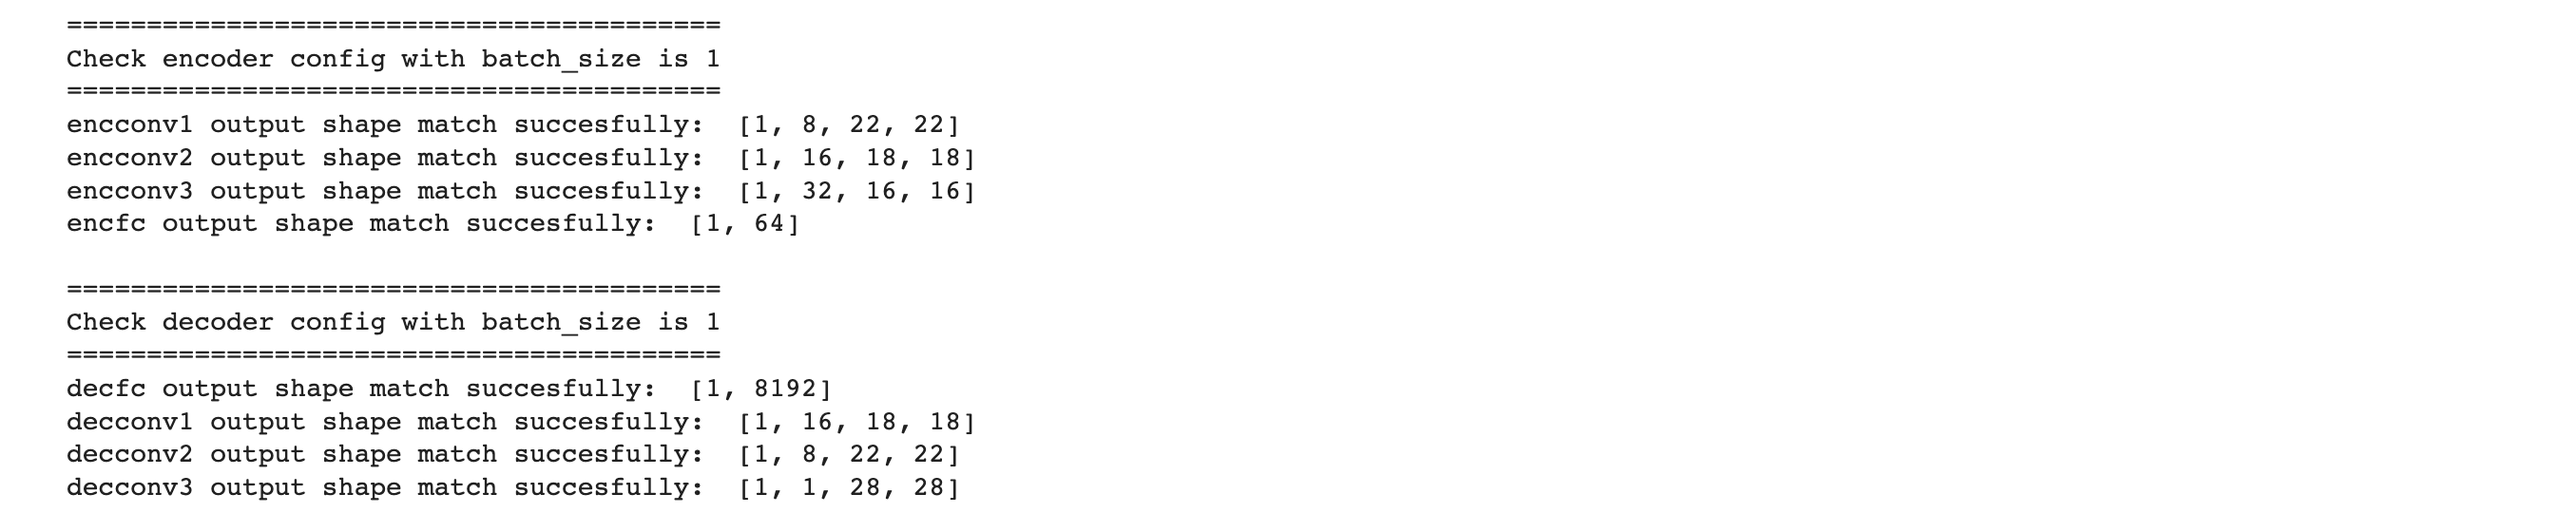

In [3]:
class VAE(nn.Module):
    def __init__(self, z_dim=256):
        super(VAE, self).__init__()
        self.z_dim = z_dim
        #############  TODO  #############

        # encoder part
        self.encconv1 = nn.Conv2d(1, 8, 7)
        self.encconv2 = nn.Conv2d(8, 16, 5)
        self.encconv3 = nn.Conv2d(16, 32, 3)
        self.encfc1 = nn.Linear(32*16*16, z_dim)
        self.encfc2 = nn.Linear(32*16*16, z_dim)

        #decoder part
        self.decfc = nn.Linear(z_dim, 32*16*16)
        self.decconv1 = nn.ConvTranspose2d(32, 16, 3)
        self.decconv2 = nn.ConvTranspose2d(16, 8, 5)
        self.decconv3 = nn.ConvTranspose2d(8, 1, 7)

    def encoder(self, x):
        x = F.relu(self.encconv1(x))
        x = F.relu(self.encconv2(x))
        x = F.relu(self.encconv3(x))
        x = x.view(-1, 32*16*16)

        return self.encfc1(x), self.encfc2(x) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        x = F.relu(self.decfc(z))
        x = x.view(-1, 32, 16, 16)
        x = F.relu(self.decconv1(x))
        x = F.relu(self.decconv2(x))
        x = torch.sigmoid(self.decconv3(x))
        return x
    
    def encoder_dimension_check(self):
        print("=========================================")
        print("Check encoder config with batch_size is 1")
        print("=========================================")

        x = torch.randn(1,1,28,28).cuda()
        x = self.encconv1(x)
        
        if list(x.shape) == [1,8,22,22]:
            print("encconv1 output shape match succesfully: ", list(x.shape))
        
        x = self.encconv2(x)
        if list(x.shape) == [1,16,18,18]:
            print("encconv2 output shape match succesfully: ", list(x.shape))
        
        x = self.encconv3(x)
        if list(x.shape) == [1,32,16,16]:
            print("encconv3 output shape match succesfully: ", list(x.shape))
        
        x = x.view(-1, 32*16*16)
        x = self.encfc1(x)
        if list(x.shape) == [1, self.z_dim]:
            print("encfc output shape match succesfully: ", list(x.shape))

    def decoder_dimension_check(self):
        print("=========================================")
        print("Check decoder config with batch_size is 1")
        print("=========================================")

        x = torch.randn(1,self.z_dim).cuda()
        x = self.decfc(x)
        if list(x.shape) == [1, 32*16*16]:
            print("decfc output shape match succesfully: ", list(x.shape))
        
        x = x.view(-1, 32, 16, 16)
        x = self.decconv1(x)
        if list(x.shape) == [1,16,18,18]:
            print("decconv1 output shape match succesfully: ", list(x.shape))
        
        x = self.decconv2(x)
        if list(x.shape) == [1,8,22,22]:
            print("decconv2 output shape match succesfully: ", list(x.shape))
        
        x = self.decconv3(x)
        if list(x.shape) == [1,1,28,28]:
            print("decconv3 output shape match succesfully: ", list(x.shape))


    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

In [4]:
z_dim = 64
vae_net = VAE(z_dim=z_dim)
vae_net.cuda()
optimizer = optim.Adam(vae_net.parameters(), lr=1e-4)

In [5]:
vae_net.encoder_dimension_check()
print()
vae_net.decoder_dimension_check()

Check encoder config with batch_size is 1
encconv1 output shape match succesfully:  [1, 8, 22, 22]
encconv2 output shape match succesfully:  [1, 16, 18, 18]
encconv3 output shape match succesfully:  [1, 32, 16, 16]
encfc output shape match succesfully:  [1, 64]

Check decoder config with batch_size is 1
decfc output shape match succesfully:  [1, 8192]
decconv1 output shape match succesfully:  [1, 16, 18, 18]
decconv2 output shape match succesfully:  [1, 8, 22, 22]
decconv3 output shape match succesfully:  [1, 1, 28, 28]


In [6]:
class VAETrainer():
    def __init__(self, trainloader, testloader, net, optimizer):

        self.trainloader = trainloader
        self.testloader = testloader
        self.net = net
        self.optimizer = optimizer

    def mse_kldloss(self, recon_x, x, mu, log_var, lamb=1):
        # TODO
        mseloss = F.mse_loss(recon_x.view(-1,1,28,28), x, reduction='sum')
        kldloss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        return (mseloss + lamb*kldloss)
        
    def train(self, epoch = 1, test_on_train=False):
        self.net.train()
        for e in range(epoch):
            running_loss = 0.0  
            for i, (inputs, _) in enumerate(self.trainloader, 0): 
                inputs = inputs.cuda()
                self.optimizer.zero_grad()    

                recon, mu, log_var = self.net(inputs)
                loss = self.mse_kldloss(recon, inputs, mu, log_var)

                loss.backward() 
                self.optimizer.step()

                # print statistics
                running_loss += loss.item()
                if (i+1) % 500 == 0:   
                    print('[%d, %5d] loss: %.3f' % (e + 1, i + 1, running_loss / (100*len(inputs))))
                    running_loss = 0.0
            if test_on_train:
                self.test()
        print('Finished Training')
        
    def test(self):
        self.net.eval() 

        test_loss = 0
        with torch.no_grad():
            for inputs, _ in self.testloader:
                inputs = inputs.cuda()
                recon, mu, log_var = self.net(inputs) 

                loss = self.mse_kldloss(recon, inputs, mu, log_var)
                test_loss += loss.item()

            test_loss /= len(self.testloader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))

In [7]:
trainer = VAETrainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = vae_net,
                  optimizer = optimizer)

In [8]:
trainer.train(epoch = 10, test_on_train=True)

[1,   500] loss: 462.117
[1,  1000] loss: 275.532
[1,  1500] loss: 232.275
====> Test set loss: 41.7086
[2,   500] loss: 203.325
[2,  1000] loss: 193.485
[2,  1500] loss: 187.723
====> Test set loss: 35.9746
[3,   500] loss: 177.967
[3,  1000] loss: 174.594
[3,  1500] loss: 170.273
====> Test set loss: 33.2768
[4,   500] loss: 165.745
[4,  1000] loss: 163.128
[4,  1500] loss: 161.289
====> Test set loss: 31.8558
[5,   500] loss: 158.145
[5,  1000] loss: 156.267
[5,  1500] loss: 155.972
====> Test set loss: 30.8234
[6,   500] loss: 152.980
[6,  1000] loss: 151.967
[6,  1500] loss: 150.522
====> Test set loss: 29.9730
[7,   500] loss: 149.266
[7,  1000] loss: 148.294
[7,  1500] loss: 147.750
====> Test set loss: 29.3034
[8,   500] loss: 146.125
[8,  1000] loss: 145.828
[8,  1500] loss: 145.519
====> Test set loss: 28.9667
[9,   500] loss: 144.282
[9,  1000] loss: 143.285
[9,  1500] loss: 143.294
====> Test set loss: 28.4937
[10,   500] loss: 141.987
[10,  1000] loss: 142.436
[10,  1500] 

### Inference

Generate 10 random images from random latent space vector.

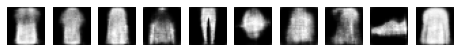

In [9]:
z = torch.randn(10,64).cuda()

sample = vae_net.decoder(z).cuda()
imgs = sample.view(-1,28,28)
imgs = imgs.detach().cpu()

fig, axes = plt.subplots(1,10,figsize=(8,8))
ax = axes.ravel()
for i in range(10):
    img = imgs[i]
    ax[i].imshow(img, cmap='gray')
    ax[i].axis('off')
plt.show()

###Problem (2 points)

Enter this [document link](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST) and check **source code** of this FashionMNIST dataset class. 

Find the FashioMNIST classes and their index. Then, make latent vector list **z** to change from "Ankle boot" class to "T-shirt/top" class. 

Then display the image generated from that z as below(Left: Ankle boot, Right: T-shirt/top).

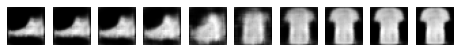

In [27]:
#############  TODO  #############

# Find index
ts_index =  0   # T-shirt/top class index
ab_index =  9   # Ankle boot class index

# Get images of correspond class
ts_image = fmnist_test.data[fmnist_test.targets==ts_index].data.view(-1,1,28,28).cuda()
ts_image = ts_image/255.0
ab_image = fmnist_test.data[fmnist_test.targets==ab_index].data.view(-1,1,28,28).cuda()
ab_image = ab_image/255.0

# Get mean value of t-shirt image and ankle boot image
ts_z_mu, ts_z_var = vae_net.encoder(ts_image)
ab_z_mu, ab_z_var = vae_net.encoder(ab_image)

z = torch.empty(10,z_dim).cuda()
alpha = torch.linspace(0,1,10)
for i in range(10):
    # Interpolate t-shirt images mean and ankle boot images mean in latent space
    z[i] = alpha[i]*ts_z_mu[0] + (1-alpha[i])*ab_z_mu[0]

# generate sample
sample = vae_net.decoder(z).cuda()
imgs = sample.view(-1,28,28)
imgs = imgs.detach().cpu()

fig, axes = plt.subplots(1,10,figsize=(8,8))
ax = axes.ravel()
for i in range(10):
    img = imgs[i]
    ax[i].imshow(img, cmap='gray')
    ax[i].axis('off')
plt.show()